# 1. fashion MNIST

### 다음의 조건을 만족하면서 test 데이터에 대한 예측의 정확도를 최대로 높여라.

* CNN을 이용한다. 그 외에 인공신경망 구조는 자유롭게 선택한다.
* model은 클래스를 이용하여 직접 작성한다.
* output은 10개(0~9)로 설정한다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import torch.nn.functional as F


train_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=100)

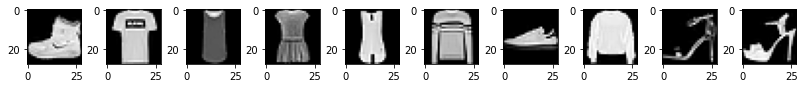

In [2]:
plt.figure(figsize=(14,1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_data.data[i],cmap=plt.cm.gray);

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [4]:
print(len(train_data),len(test_data))

60000 10000


In [5]:
#GPU 사용 설정, seed 설정
print(torch.cuda.is_available())
device=torch.device('cuda')
torch.cuda.manual_seed_all(10)
torch.manual_seed(10)

True


In [6]:
class yalgae(nn.Module):
    def __init__(self):
        super(yalgae, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) #(C, H, W) (1,28,28) => (32,28,28) => (32,28,28) => (32,14,14) 
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            #nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) #(C, H, W) (32,14,14) => (64,12,12) => (64,12,12) => (64, 6, 6)
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [7]:
model = yalgae()
model.to(device)

error = nn.CrossEntropyLoss() # 두 개의 인자로 input, target을 받는데 target이 정수(1-D 토치텐서)여도 상관없음 (one-hot encoding 안해도 됨)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

yalgae(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [8]:
num_epochs = 5

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): # batch size 100이므로 epoch 당 iteration=60000/100=600 번 
        images, labels = images.to(device), labels.to(device)
    
        prediction = model(images)
        
        loss = error(prediction, labels)
        
        optimizer.zero_grad()
    
        loss.backward()
        
        optimizer.step()
     
        if ((i+1)%100==0): # iteration 100번마다 test data로 loss, accuracy 계산하여 학습 경향 확인하기
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                prediction = model(images) 
            
                predictions = torch.max(prediction, 1)[1].to(device) 
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(i)
            accuracy_list.append(accuracy)
            print("Epoch:{}, Iteration: {}, Loss: {}, Accuracy: {}%".format(epoch+1,i+1, loss.data, accuracy))
    
    

Epoch:1, Iteration: 100, Loss: 0.5566796660423279, Accuracy: 80.04000091552734%
Epoch:1, Iteration: 200, Loss: 0.4325866997241974, Accuracy: 83.97000122070312%
Epoch:1, Iteration: 300, Loss: 0.46413394808769226, Accuracy: 84.45999908447266%
Epoch:1, Iteration: 400, Loss: 0.3849591910839081, Accuracy: 85.75%
Epoch:1, Iteration: 500, Loss: 0.40998199582099915, Accuracy: 86.3499984741211%
Epoch:1, Iteration: 600, Loss: 0.261903315782547, Accuracy: 86.41999816894531%
Epoch:2, Iteration: 100, Loss: 0.2660926878452301, Accuracy: 87.20999908447266%
Epoch:2, Iteration: 200, Loss: 0.28284120559692383, Accuracy: 88.25%
Epoch:2, Iteration: 300, Loss: 0.3180243670940399, Accuracy: 85.93000030517578%
Epoch:2, Iteration: 400, Loss: 0.317714661359787, Accuracy: 89.00999450683594%
Epoch:2, Iteration: 500, Loss: 0.3160257339477539, Accuracy: 88.69999694824219%
Epoch:2, Iteration: 600, Loss: 0.21431608498096466, Accuracy: 88.0%
Epoch:3, Iteration: 100, Loss: 0.21266357600688934, Accuracy: 88.82999420166

# 2. 아래의 글을 읽고 500자 이내로 감상문을 작성하세요.

https://webzine.kps.or.kr/?p=5_view&idx=16537

단백질 구조 예측 대회(CASP13)에서 딥마인드와 베이커 그룹의 경쟁을 다루고 있다. 결과적으로 단백질 구조를 오래 연구해온 구조 생물학 전공자들은 AI/머신러닝 엔지니어들에게 뒤쳐졌다. 단백질 접힌 구조를 예측 문제는 오랜 시간 rule based 알고리듬으로 해결하지 못하였다. 딥마인드가 만든 Alphafold1이 기존 방식보다 머신러닝을 이용한 방식의 성능이 압도적임을 보였다. 베이커 그룹은 배열 사이의 거리 뿐만 아니라 각도 정보 까지 학습할 수 있는 모델을 완성하여 Alphafold1을 앞질렀다. 단순한 수학적인 아이디어 만으로 따라잡힌 딥마인드 였지만 Attention mechanism을 도입한 새로운 모델로 압도적인 차이로 다시 베이커 그룹을 앞질렀다. 현재 딥마인드 홈페이지에는 사용한 dataset과 코드가 모두에게 공개되어있고 자신들의 AI기술이 다양한 연구에 활용될 수 있음을 강조한다. 이처럼 머신러닝 기술자들이 과학에 기여를 하는 내용을 보며 머신러닝 분야에 관심이 올라갔고 Attention과 Transformer를 공부 할 의향이 생겼다. 